In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torchvision import models, utils
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
batch_size = 8
num_epoch = 10
# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint7'


In [4]:
# 생성한 test 폴더 하위에 있는 test_data 폴더의 이미지들을 텐서로 변환하여 불러옴
trans = transforms.Compose([
    transforms.ToTensor()
])

test_data = torchvision.datasets.ImageFolder(root='D:/torchtorch/data/test_data/', transform=trans)

In [5]:
# load 데이터 정보 확인
test_data

Dataset ImageFolder
    Number of datapoints: 234
    Root location: D:/torchtorch/data/test_data/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
data_loader = DataLoader(dataset = test_data, batch_size = 8, shuffle = False)

# 1배치에 들어갈 데이터 
# 1epoch = 234 = 8batch
# 1batch = 234/8(batch_size) = 30
num_data = len(data_loader.dataset)
num_batch = np.ceil(num_data / batch_size)
print(num_data)
print(num_batch)

234
30.0


In [7]:
class Pokemon_CNN(nn.Module):
    def __init__(self):
        super(Pokemon_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 6, kernel_size = 5, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features = 16*13*29, out_features = 120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 120,out_features = 5, bias=True)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = self.layer3(out)
        return out

In [8]:
## 네트워크 설정 및 필요한 손실함수 구현하기
net = Pokemon_CNN().to(device)
params = net.parameters()

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(params, lr=lr)

# train과 다른점 - load
net, optim = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

In [13]:
print(net)

Pokemon_CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=6032, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=5, bias=True)
  )
)


In [9]:
## evaluation 시작하기
predictions_list = []
labels_list = []

with torch.no_grad():
    net.eval()

    loss_arr = []
    acc_arr = []

    # 다른점 - backpropagation 과정 제거
    for batch, (input, label) in enumerate(data_loader, 1):
        
        input = input.to(device)
        label = label.to(device)
        labels_list.append(label)

        output = net(input)
        pred = fn_pred(output)

        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)

        predictions_list.append(torch.max(output,1)[1])
        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TEST: BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))

TEST: BATCH 0001/0030 | LOSS: 0.1382 | ACC 1.0000
TEST: BATCH 0002/0030 | LOSS: 0.3894 | ACC 0.8750
TEST: BATCH 0003/0030 | LOSS: 0.4441 | ACC 0.8750
TEST: BATCH 0004/0030 | LOSS: 0.6928 | ACC 0.7500
TEST: BATCH 0005/0030 | LOSS: 0.6487 | ACC 0.7500
TEST: BATCH 0006/0030 | LOSS: 0.5973 | ACC 0.7708
TEST: BATCH 0007/0030 | LOSS: 0.5498 | ACC 0.7857
TEST: BATCH 0008/0030 | LOSS: 0.5136 | ACC 0.7969
TEST: BATCH 0009/0030 | LOSS: 0.5774 | ACC 0.7917
TEST: BATCH 0010/0030 | LOSS: 0.7046 | ACC 0.7750
TEST: BATCH 0011/0030 | LOSS: 0.6413 | ACC 0.7955
TEST: BATCH 0012/0030 | LOSS: 0.6619 | ACC 0.8021
TEST: BATCH 0013/0030 | LOSS: 0.6255 | ACC 0.8077
TEST: BATCH 0014/0030 | LOSS: 0.5812 | ACC 0.8214
TEST: BATCH 0015/0030 | LOSS: 0.5435 | ACC 0.8333
TEST: BATCH 0016/0030 | LOSS: 0.5100 | ACC 0.8438
TEST: BATCH 0017/0030 | LOSS: 0.5175 | ACC 0.8456
TEST: BATCH 0018/0030 | LOSS: 0.4893 | ACC 0.8542
TEST: BATCH 0019/0030 | LOSS: 0.5115 | ACC 0.8487
TEST: BATCH 0020/0030 | LOSS: 0.4891 | ACC 0.8562


In [10]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

print(predictions_l)
print(labels_l)

[0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 4, 4, 2, 2, 0, 0, 0, 0, 2, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 0, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 0, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 2, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [11]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.88      0.76      0.81        37
           1       0.96      0.83      0.89        52
           2       0.83      0.94      0.88        51
           3       0.86      0.84      0.85        45
           4       0.75      0.84      0.79        49

    accuracy                           0.85       234
   macro avg       0.85      0.84      0.84       234
weighted avg       0.85      0.85      0.85       234




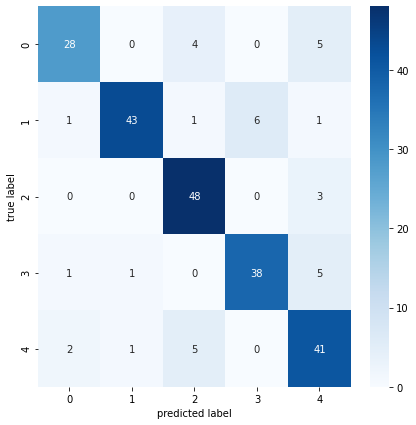

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬을 만듭니다.
plt.figure(figsize = (7, 7))
cm = confusion_matrix(labels_l, predictions_l)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()